# Descente de gradient et perceptron

In [1]:
# On code de quoi créer et utiliser un perceptron

# On importe d'abord les modules nécessaires à l'exécution du code ci-dessous

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

# Dictionnaire contenant diverses fonctions d'activation

dict_activation_funct = {"heaviside": lambda z: (z >= 0).astype(int),
                         "sigmoid_thresholded": lambda z: (1 / (1 + np.exp(-z)) >= 0.5).astype(int),
                         "sigmoid": lambda z: 1 / (1 + np.exp(-z)),
                        "identity": lambda z: z}

# Dictionnaire contenant les fonctions permettant de créer les labels pour nos données (le vecteur cible ou 'target')

dict_target_funct = {"0": lambda data: 2 * data[0] + data[1] >= 7, "1": lambda data: np.abs((data[0] + data[1])) >= 1}

# On code deux fonctions qui permettront de créer le vecteur contenant les labels associés aux exemples de notre dataset

def make_target_bool(data, target_function):  # Fonction pour créer un vecteur cible / une target de booléens
    return dict_target_funct[target_function](data)


def make_target_int(target_bool):  # Fonction pour créer les labels (représentés par des entiers valent ici 1 ou 0)
    # associés aux exemples de notre dataset, c'est-à-dire le vecteur cible ou target, à partir d'un vecteur de booléens
    return target_bool.astype(int)

In [2]:
# On définit d'abord deux fonctions de coût différentes, la première correspond à celle des moindres carrés et sert pour la régression. 
# L'autre permet de faire de la classification. C'est la différence, en valeurs absolue, entre deux valeurs binaires : la prédiction faite par le modèle et la véritable classe ou le vrai label 
# qu'il fallait prédire

def MSE_cost_function(target, prediction):
    return 0.5 * np.mean(np.square(target - prediction))

def classification_cost_function(target, prediction):
    return np.sum(np.abs(prediction - target))

# On définit la classe mère perceptron, et deux classes filles pour adapter la fonction de coût et le comportement de la fonction de mise à jour selon que l'on souhaite faire une tâche de classification 
# ou de régression, un paramètre supplémentaire permettant de spécifier la méthode de descente de gradient utilisée pour ce faire : stochastique ou par batch.

# On crée la classe Perceptron qui reprend le fonctionnement basique d'un perceptron

class Perceptron:

    def __init__(self, weights, bias, learning_rate, activation_funct):
        self.__weights = weights
        self.__bias = bias
        self.__learning_rate = learning_rate
        self.__activation_funct = dict_activation_funct[activation_funct]
        self.__cost_function = None 
        self.__gradient_descent_method = None
        
    def get_gradient_descent_method(self):
        return self.__gradient_descent_method
            
    def set_gradient_descent_method(self, gradient_descent_method):
        self.__gradient_descent_method = gradient_descent_method
    
    def get_weights(self):
        return self.__weights

    def get_bias(self):
        return self.__bias

    def get_learning_rate(self):
        return self.__learning_rate
    
    def update_learning_rate(self, update_function):
        self.__learning_rate = update_function(self.get_learning_rate())
    
    def get_cost_function(self):
        return self.__cost_function
    
    def set_cost_function(self, cost_function):
        self.__cost_function = cost_function

    def set_weights(self, new_weights):
        self.__weights = new_weights

    def set_bias(self, new_bias):
        self.__bias = new_bias

    def set_learning_rate(self, new_learning_rate):
        self.__learning_rate = new_learning_rate

    def make_net(self, data):
        return np.dot(data, self.get_weights()) + self.get_bias()

    def activation(self, z):
        return self.__activation_funct(z)

    def feed_forward(self, data):
        z = self.make_net(data)
        return self.activation(z)

    def update(self, data, prediction, target):
        pass

    def training(self, data, target, error=True):
        prediction = self.feed_forward(data)
        self.update(data, prediction, target)
        if error:
            cost_function = self.get_cost_function()
            return cost_function(target, prediction)

    def hyperplan(self, data):
        last_weight = self.get_weights()[len(self.get_weights()) - 1:len(self.get_weights())]
        if data.ndim == 1:
            return -(data * self.get_weights()[:len(self.get_weights()) - 1] + self.get_bias()) / last_weight
        return -(np.dot(data, self.get_weights()[:len(self.get_weights()) - 1]) + self.get_bias()) / last_weight 
        
# On crée la classe Classifier pour faire de la classification. Quand on utilise la méthode de descente de gradient stochastique, on a alors le perceptron de Rosenblatt

class Classifier(Perceptron):
    
    def __init__(self, weights, bias, learning_rate, activation_funct, gradient_descent_method):
        super(Classifier, self).__init__(weights, bias, learning_rate, activation_funct)
        self.set_cost_function(classification_cost_function)
        self.set_gradient_descent_method(gradient_descent_method)
    
    def update(self, data, prediction, target):
        if self.get_gradient_descent_method() == "SGD":
            alpha_loss = self.get_learning_rate() * (target - prediction)
            updated_weights = self.get_weights() + alpha_loss * data
            updated_bias = self.get_bias() + alpha_loss
            self.set_weights(updated_weights)
            self.set_bias(updated_bias)
        elif self.get_gradient_descent_method() == "BGD":
            nb_exemples = data.shape[0]
            alpha_loss = self.get_learning_rate() * (target - prediction)
            updated_weights = self.get_weights() + (1 / nb_exemples) * np.dot(alpha_loss, data)
            updated_bias = self.get_bias() + np.mean(alpha_loss)
            self.set_weights(updated_weights)
            self.set_bias(updated_bias)
            

                
# On crée la classe regressor pour faire des tâches de régression, notamment de régression linéaire

class Regressor(Perceptron):
    
    def __init__(self, weights, bias, learning_rate, activation_funct, gradient_descent_method):
        super(Regressor, self).__init__(weights, bias, learning_rate, activation_funct)
        self.set_cost_function(MSE_cost_function)
        self.set_gradient_descent_method(gradient_descent_method)
        
    def update(self, data, prediction, target):
        if self.get_gradient_descent_method() == "SGD":
            updated_weights = self.get_weights() - self.get_learning_rate() * np.dot(prediction - target, data)
            updated_bias = self.get_bias() - self.get_learning_rate() * (prediction - target)
            self.set_weights(updated_weights)
            self.set_bias(updated_bias)

        elif self.get_gradient_descent_method() == "BGD":
            nb_exemples = target.shape[0]
            updated_weights = self.get_weights() - self.get_learning_rate() * (1 / nb_exemples) * np.dot(prediction - target, data)
            updated_bias = self.get_bias() - self.get_learning_rate() * np.mean(prediction - target)
            self.set_weights(updated_weights)
            self.set_bias(updated_bias)
    
    
# On code deux fonctions qui permettront de créer le vecteur contenant les labels associés aux exemples de notre dataset

def make_target_bool(data, target_function):  # Fonction pour créer un vecteur cible / une target de booléens
    return dict_target_funct[target_function](data)


def make_target_int(target_bool):  # Fonction pour créer les labels (représentés par des entiers valent ici 1 ou 0)
    # associés aux exemples de notre dataset, c'est-à-dire le vecteur cible ou target, à partir d'un vecteur de booléens
    return target_bool.astype(int)

# Classification

# Descente de gradient Stochastique 

On va d'abord s'intéresser à la descente de gradient stochastique sur des problèmes de classification.

## Un premier jeu de données fictives

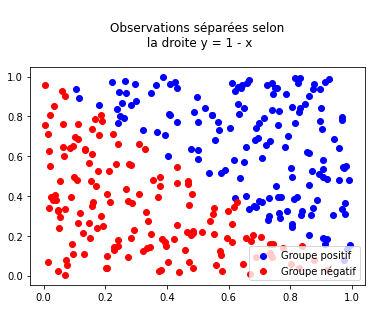

In [3]:
# On crée un générateur Numpy pour simuler différentes lois de probabilités et ainsi créer des échantillons
# d'observations suivant ces lois. On crée ainsi des jeux de données fictifs

rng = default_rng(180)  # On fixe une valeur arbitraire afin d'assurer la reproductibilité des résultats. Ici 180.

# On crée un perceptron et un tableau errors qui stockera les erreurs faites lors de l'entraînement

# On initialise d'abord les hyperparamètres

weights = rng.random(2)  # On initialise les poids du perceptron aléatoirement
bias = 1  # On fixe le biais arbitrairement à 1 
learning_rate = 0.5
activation_function = "heaviside"
gradient_descent_method = "SGD"  # On commence donc par une descente de gradient stochastique

perceptron = Classifier(weights, bias, learning_rate, activation_function, "SGD")  # On crée le perceptron, qui ici est un classifieur linéaire

# On crée un jeu de données fictives de 1000 observations avec 2 features qui suivent chacune une loi uniforme sur [0, 1]
# Puis on affiche les points ainsi créés, ceux étant en dessous de la droite d'équation x + y = 1 étant en bleu et
# représentant la classe des exemples négatifs, alors que ceux en rouge sont au-dessus et représentent la classe des
# positifs

N = 1100  # taille de l'échantillon de loi normale
Ntrain = 1000  # taille du dataset d'entraînement. On va donc mettre de côté 100 exemples pour créer un dataset de test/validation sur lequel on pourra tester les réelles performances de notre modèle,
# i.e tester sa capacité de généralisation en l'évaluant sur des données qu'il n'a encore jamais vu durant son entraînement.

# On affiche une partie du dataset pour visualiser la répartition des données

loi_test = rng.random((N, 2))
loi_test = loi_test.T
bool_filter = make_target_bool(loi_test, "1")
plt.scatter(loi_test[0][bool_filter][:150], loi_test[1][bool_filter][:150], color='b', label="Groupe positif")
plt.scatter(loi_test[0][bool_filter != True][:150], loi_test[1][bool_filter != True][:150], color='r', label="Groupe négatif")
plt.title("\nObservations séparées selon\n la droite y = 1 - x\n")
plt.legend()
plt.show()

loi_test = loi_test.T  # On redimensionne les données pour permettre l'entraînement

# On crée un dataset d'entraînement, et un de validation avec à l'intérieur un peu moins de 10 % de nos données initiales

train_set = loi_test[:-100]
test_set = loi_test[-100:]

target = make_target_int(bool_filter)  # On crée le vecteur cible qui contient les vrais labels des exemples
train_target = target[:-100]
test_target = target[-100:]

# On crée un tableau d'entiers qui représentent des indices et qui nous servira à tirer un exemple de façon aléatoire
# tout en lui associant le bon label dans le vecteur cible

randomize = np.arange(Ntrain)  # On crée le tableau d'entiers
rng.shuffle(randomize)  # On le mélange

## Entraînement du perceptron.


Affichage de l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement


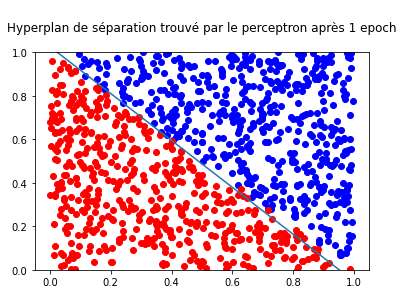

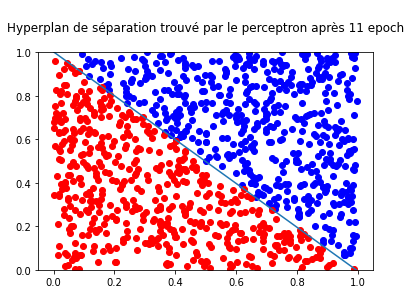

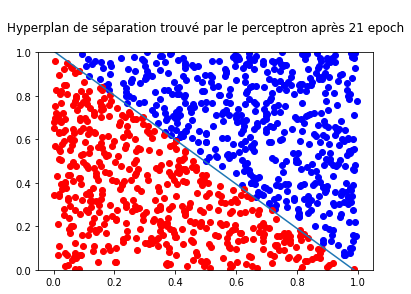

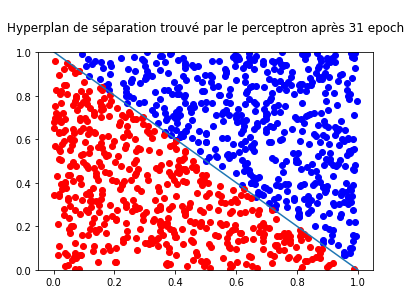

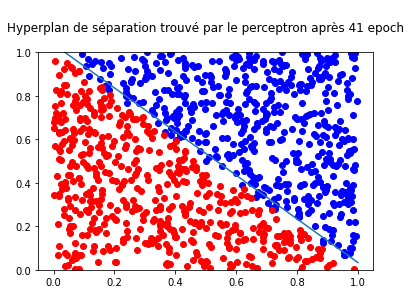

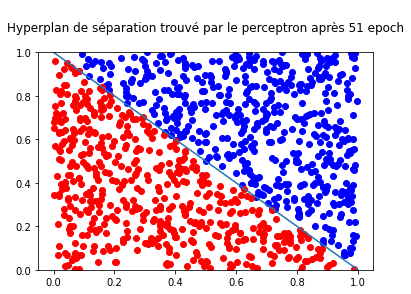

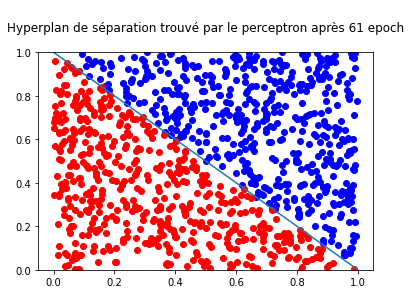

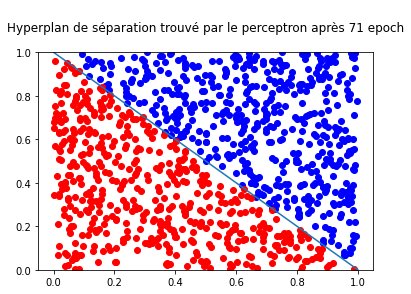

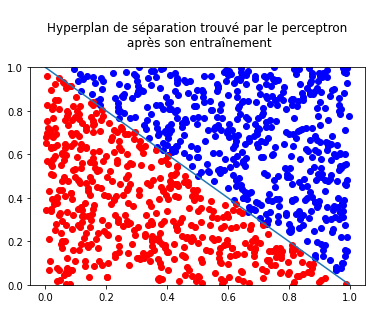

In [4]:
# On entraîne le perceptron

errors = np.array([])  # Le tableau Numpy pour sotcker les erreurs

epochs = 80  # On fixe le nombre d'epochs, c'est-à-dire le nombre de fois où l'on va itérer sur toute la longueur de
# notre dataset (On pourrait dire sur tout le dataset si les exemples du jeu de données n'étaient pas tirés au hasard
# et que l'on était sûr de passer en revue tous les exemples du dataset lors d'une epoch)

print("\nAffichage de l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement")

for j in range(epochs):
    for i in range(Ntrain):
        rng.shuffle(randomize)
        errors = np.append(errors, perceptron.training(train_set[randomize[i]], train_target[randomize[i]]))
    if not j % 10:  # On affiche l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement
        train_set_plot = train_set.T
        bool_filter = make_target_bool(train_set_plot, "1")
        plt.scatter(train_set_plot[0][bool_filter], train_set_plot[1][bool_filter], color='b')
        plt.scatter(train_set_plot[0][bool_filter != True], train_set_plot[1][bool_filter != True], color='r')
        plt.plot(np.linspace(0, 1, Ntrain), perceptron.hyperplan(np.linspace(0, 1, Ntrain)))
        plt.ylim(0, 1)
        plt.title("\nHyperplan de séparation trouvé par le perceptron après {} epoch\n".format(j + 1))
        plt.show()
        
# On affiche à nouveau le jeu de données d'entraînement avec les deux classes distinctes, en traçant cette fois l'hyperplan trouvé
# par le perceptron (ici une droite) à la fin de son entraînement, et qui sépare les points selon ces deux classes

train_set_plot = train_set.T
bool_filter = make_target_bool(train_set_plot, "1")
plt.scatter(train_set_plot[0][bool_filter], train_set_plot[1][bool_filter], color='b')
plt.scatter(train_set_plot[0][bool_filter != True], train_set_plot[1][bool_filter != True], color='r')
plt.plot(np.linspace(0, 1, Ntrain), perceptron.hyperplan(np.linspace(0, 1, Ntrain)))
plt.ylim(0, 1)
plt.title("\nHyperplan de séparation trouvé par le perceptron\n après son entraînement\n")
plt.show()

On observe sur le premier graphique en bas à droite quelques points rouges mal classés. Ils se situent en effet au-dessus de la droite alors qu'ils devraient être en-dessous étant donné leur couleur, mais après seulement une seule epoch on a déjà une droite très convenable. On voit ensuite qu'elle sépare parfaitement ou presque les données d'entraînement. 

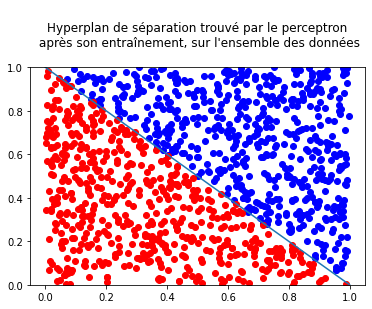

In [5]:
# On affiche encore l'hyperplan de séparation trouvé par le perceptron, sur l'ensemble des données cette fois

bool_filter = make_target_bool(loi_test.T, "1")  # Le vecteur target avec des booléens nous sert de filtre booléen
plt.scatter(loi_test.T[0][bool_filter], loi_test.T[1][bool_filter], color='b')  # Avec le filtre booléen, on sélectionne
# les exemples dits positifs
plt.scatter(loi_test.T[0][bool_filter != True], loi_test.T[1][bool_filter != True], color='r')  # Ici, on crée un nouveau
# filtre booléen à partir du premier, en prenant son opposé, ce qui permet de sélectionner cette fois tous les exemples
# négatifs
plt.plot(np.linspace(0, 1, N), perceptron.hyperplan(np.linspace(0, 1, N)))
plt.title("\nHyperplan de séparation trouvé par le perceptron\n après son entraînement, sur l'ensemble des données\n")
plt.ylim(0, 1)
plt.show()

L'affichage de l'hyperplan par rapport à l'ensemble des données ne change pas grand chose, la droite a l'air globalement de très bien séparer les données.

Nous n'avons pas reproduit tous nos essais dans ce Notebook, mais il convient de souligner un résultat qui porte sur les problèmes de classification linéaires, c'est-à-dire où l'on peut séparer correctement toutes les données grâce à un hyperplan. Si le pas est suffisamment petit, le classifieur linéaire converge toujours. On observe alors généralement, en tout cas dans le cas stochastique, que le nombre d'erreurs par epoch décroît très rapidement avant d'osciller pendant une longue période avant de devenir finalement nul (avec un pas constant du moins). Cela signifie que si le perceptron s'améliore globalement très vite et fait un nombre acceptable d'erreurs, il met en revanche longtemps avant de ne commetre plus aucune erreur et de classer parfaitement tous les exemples (modulo le fait qu'on ait pu laissé un exemple de côté à cause du tirage aléatoire). Autrement dit, il met un moment avant de trouver un hyperplan qui sépare parfaitement toutes les données selon leur label respectif. Cela illustre très bien les propos de Léon Bottou, dans le cas général de la convergence des algorithmes stochastique, où l'on a une pahse de descente vers la zone du minimum qui est souvent rapide, puis une seconde phase dite de confinement global où l'on oscille autour du minimum, parfois longtemps, en raison du comportement stochastique de l'algorithme. 

## Erreurs commises lors de l'entraînement

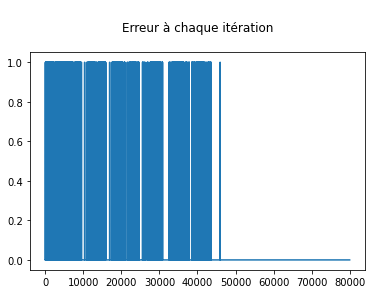

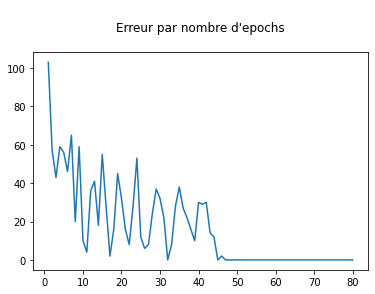

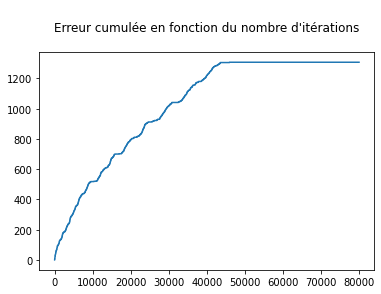

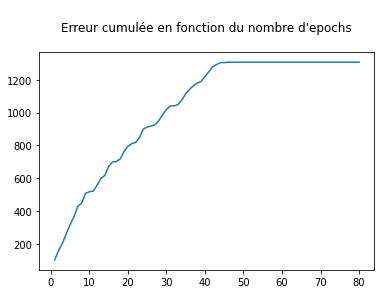

In [6]:
# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque itération\n")
plt.show()

# On affiche maintenant le nombre d'erreurs par epoch

errors_per_epoch = np.add.reduceat(errors, np.arange(0, epochs * Ntrain, Ntrain))

plt.plot(np.arange(1, epochs + 1), errors_per_epoch)
plt.title("\nErreur par nombre d'epochs\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'itérations

plt.plot(np.arange(1, epochs * Ntrain + 1), np.cumsum(errors))
plt.title("\nErreur cumulée en fonction du nombre d'itérations\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'epochs

plt.plot(np.arange(1, epochs + 1), np.cumsum(errors_per_epoch))
plt.title("\nErreur cumulée en fonction du nombre d'epochs\n")
plt.show()

Si l'erreur sur le dataset d'entraînement décroît au début, elle oscille assez fortement lors des 40 000 premières itérations. Puis elle finit par être nulle de la 50 000-ième à la 80 000-ième itération. On observe donc que l'algorithme converge assez vite vers une zone de minima, mais qu'il met beaucoup de temps avant de vraiment pouvoir classer tous les exemples correctement et avoir une erreur nulle, c'est-à-dire pour converger vers le minimum global. C'est pour cela que l'on observe un plateau de l'erreur cumulée vers les 50 000 itérations : le modèle ne fait plus d'erreur, donc l'erreur cumulée n'augmente plus et reste constante. 

## Évaluation de la capacité de généralisation

On teste cette fois le perceptron sur le jeu de données de validation, c'est-à-dire des données que l'on a gardé de côté et que le perceptron n'a jamais vu. On veut mesurer sa performance sur des 
données qu'il n'a pas vu pendant son entraînement afin de voir s'il arrive à généraliser correctement. Cette pratique a notamment pour but d'éviter l'overfitting. En effet, le perceptron a peut-être
adapté correctement ses paramètres afin de fournir les bonnes réponses relativement aux données d'entraînement qu'il connaît, mais il est possible qu'en général il se trompe quand il doit évaluer des 
observations provenant de la vraie distribution du phénomène qu'on cherche à prédire, et qui ne saurait se limiter à un dataset fini particulier. 

Pourcentage d'erreur sur le dataset de validation : 0.0%


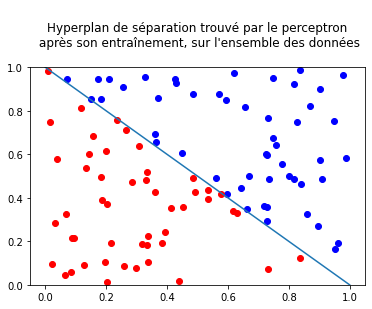

In [7]:
predictions = perceptron.feed_forward(test_set)
cost_function = perceptron.get_cost_function()
erreur = cost_function(test_target, predictions)
print("Pourcentage d'erreur sur le dataset de validation : {}%".format(erreur * 100 / len(test_target)))

# On affiche à nouveau l'hyperplan, mais en affichant cette fois seulement les données du dataset de test/validation, pour avoir une idée plus claire de la performance du classifieur sur ces données là.

bool_filter = make_target_bool(test_set.T, "1")  # Le vecteur target avec des booléens nous sert de filtre booléen
plt.scatter(test_set.T[0][bool_filter], test_set.T[1][bool_filter], color='b')  # Avec le filtre booléen, on sélectionne
# les exemples dits positifs
plt.scatter(test_set.T[0][bool_filter != True], test_set.T[1][bool_filter != True], color='r')  # Ici, on crée un nouveau
# filtre booléen à partir du premier, en prenant son opposé, ce qui permet de sélectionner cette fois tous les exemples
# négatifs
plt.plot(np.linspace(0, 1, N), perceptron.hyperplan(np.linspace(0, 1, N)))
plt.title("\nHyperplan de séparation trouvé par le perceptron\n après son entraînement, sur l'ensemble des données\n")
plt.ylim(0, 1)
plt.show()

Le perceptron a une précision de 100%. Il est donc vraiment performant. On remarque que la droite qu'il trouve sépare parfaitement les points. Néanmoins, si l'on avait arrêté l'entraînement plus tôt, on aurait une précision un peu moins grande. Il est arrivé que l'on observe 98% de précision par exemple, la droite séparait les données à l'exception de deux points donc, qu'il était aisé d'identifier.
Nous verrons dans la suite des cas où la différence entre le jeu de données d'entraînement et celui de test ou validation apparaît plus nettement

# Descente de gradient stochastique avec pas adaptatif

In [8]:
# On initialise d'abord les hyperparamètres, avec une learning rate = 1, mais qui cette fois va changer à chaque itération et décroître en 1 / t. 

epochs = 80

bias = 1  
learning_rate = 1 
activation_function = "heaviside"
gradient_descent_method = "SGD" 

def update_function(learning_rate):
    return learning_rate / (learning_rate + 1)

perceptron = Classifier(weights, bias, learning_rate, activation_function, "SGD")  # On crée le perceptron, qui ici est un classifieur linéaire
errors = np.array([])  # Le tableau Numpy pour sotcker les erreurs

for j in range(epochs):
    for i in range(Ntrain):
        rng.shuffle(randomize)
        errors = np.append(errors, perceptron.training(train_set[randomize[i]], train_target[randomize[i]]))
        perceptron.update_learning_rate(update_function)   

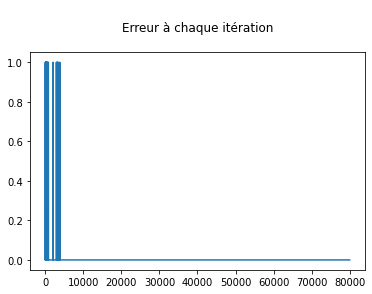

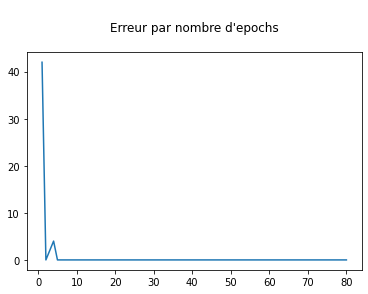

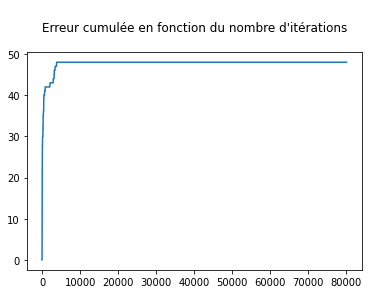

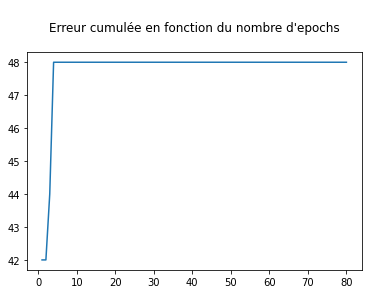

In [9]:
# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque itération\n")
plt.show()

# On affiche maintenant le nombre d'erreurs par epoch

errors_per_epoch = np.add.reduceat(errors, np.arange(0, epochs * Ntrain, Ntrain))

plt.plot(np.arange(1, epochs + 1), errors_per_epoch)
plt.title("\nErreur par nombre d'epochs\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'itérations

plt.plot(np.arange(1, epochs * Ntrain + 1), np.cumsum(errors))
plt.title("\nErreur cumulée en fonction du nombre d'itérations\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'epochs

plt.plot(np.arange(1, epochs + 1), np.cumsum(errors_per_epoch))
plt.title("\nErreur cumulée en fonction du nombre d'epochs\n")
plt.show()

Les graphiques parlent d'eux-mêmes. Avec le pas adaptatif, la convergence est incroyablement accélérée. On a très vite une chute à 0. C'est facilement compréhensible. Le perceptron trouve en général assez vite la zone où l'erreur décroît. Ensuite, classer correctement tous les exemples est difficile dans la mesure où si le pas est constant et pas suffisamment petit, l'hyperplan peut osciller entre deux points très proches mais avec deux labels différents. Il n'arrivera pas à ajuster les poids assez finement pour se décaler juste de ce qu'il faut pour passer entre ces deux points. C'est l'idée à comprendre et qui fait que la convergence peut être compliquée, mais avec le pas adaptatif on est certain qu'à partir d'un moment il est suffisamment petit pour faire des ajustements assez fins et converger vers le maximum global, ou plus exactement un maximum global puisque plusieurs hyperplans peuvent séparer les données correctement. 

Sans trop de surprise, l'erreur est également nulle sur le dataset de test/validation, il n'est pas intéressant ici de reproduire les résultats.

# Avec un pas qui décroît trop rapidement 

In [10]:
# On veut maintenant illustrer les soucis qui peuvent se présenter lorsque le pas adaptatif décroît trop vite

# Attention : on utilise ici 200 epochs donc il faut attendre un peu (parfois une bonne minute) avant que les résultats s'affichent, mais on est ainsi pratiquement sûr qu'il n'y a jamais 
# convergence. 

# On initialise d'abord les hyperparamètres, avec une learning rate = 1, mais qui cette fois va changer à chaque itération et décroître en 1 / t². 

rng = default_rng(190) 

epochs = 200

bias = 1  
learning_rate = 1 
activation_function = "heaviside"
gradient_descent_method = "SGD" 

def update_function2(learning_rate):
    return np.square(learning_rate / (learning_rate + 1))

perceptron = Classifier(weights, bias, learning_rate, activation_function, "SGD")  # On crée le perceptron, qui ici est un classifieur linéaire
errors = np.array([])  # Le tableau Numpy pour sotcker les erreurs

for j in range(epochs):
    for i in range(Ntrain):
        rng.shuffle(randomize)
        errors = np.append(errors, perceptron.training(train_set[randomize[i]], train_target[randomize[i]]))
        perceptron.update_learning_rate(update_function2)   

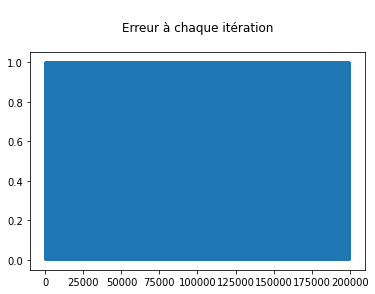

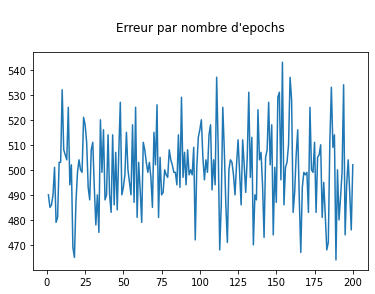

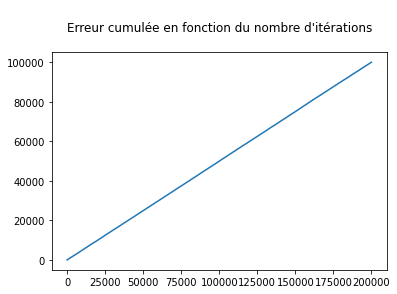

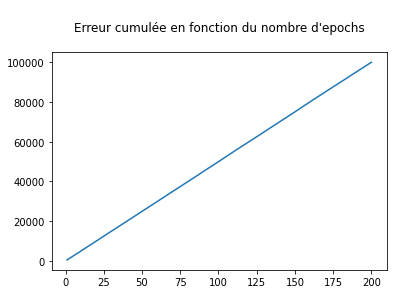

In [11]:
# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque itération\n")
plt.show()

# On affiche maintenant le nombre d'erreurs par epoch

errors_per_epoch = np.add.reduceat(errors, np.arange(0, epochs * Ntrain, Ntrain))

plt.plot(np.arange(1, epochs + 1), errors_per_epoch)
plt.title("\nErreur par nombre d'epochs\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'itérations

plt.plot(np.arange(1, epochs * Ntrain + 1), np.cumsum(errors))
plt.title("\nErreur cumulée en fonction du nombre d'itérations\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'epochs

plt.plot(np.arange(1, epochs + 1), np.cumsum(errors_per_epoch))
plt.title("\nErreur cumulée en fonction du nombre d'epochs\n")
plt.show()

Le premier graphique montre bien que des erreurs sont commises à chaque itérations, ou en tout cas à chaque epoch sans aucun doute. L'erreur par nombre d'epoch montre de nombreuses oscillations, sans que l'on ne se dirige vers un minimum. Ces oscillations semblent se répéter indéfiniment. 
C'est donc sans surprise que la courbe de l'erreur cumulée affiche une croissance linéaire, puisque l'on commet grosso modo toujours le même nombre d'erreur compris entre 470 et 540. On ajoute donc toujours plus ou moins la même quantité d'erreur en quelques sortes.

D'où l'importance, soulignée dans le papier de 1998 de Léon Bottou (version revisité de 2018), de respecter la condition venant de la théorie de l'approximation stochastique qui est que la somme des pas de descente décroissant doit être égale à l'infini.   

# Descente de gradient par *batch*

On recommence tout ce qui a été fait, à pas constant du moins, cette fois-ci avec la méthode de descente de gradient par batch. Le but est de comparer les performances des deux algorithmes, notamment en termes de vitesse de convergence.

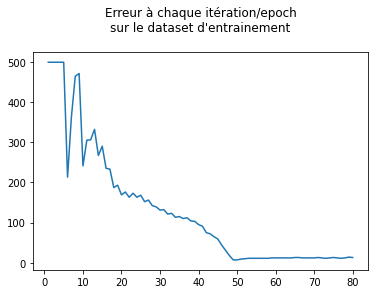

In [12]:
gradient_descent_method = "BGD"
learning_rate = 0.5

perceptron2 = Classifier(weights, bias, learning_rate, activation_function, gradient_descent_method)  # On crée le perceptron, qui ici est un classifieur linéaire
errors = np.array([])  # Le tableau Numpy pour sotcker les erreurs

epochs = 80

for j in range(epochs):
    errors = np.append(errors, perceptron2.training(train_set, train_target))

# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("Erreur à chaque itération/epoch\nsur le dataset d'entrainement\n")
plt.show()

In [13]:
# On regarde la précision sur le dataset de test/validation maintenant 

predictions = perceptron2.feed_forward(test_set)
cost_function = perceptron2.get_cost_function()
erreur = cost_function(test_target, predictions)
print("\nPourcentage d'erreur sur le dataset de validation : {}%\n".format(erreur * 100 / len(test_target)))


Pourcentage d'erreur sur le dataset de validation : 2.0%



Si on choisit 20 epochs pour un learning rate de 0.5, on voit que l'algorithme a convergé mais il fait un peu moins bien que la descente de gradient stochastique sur le jeu de données de validation. D'après les tests que l'on a fait en arrêtant l'entraînement après que chaque algorithme ait vu 20 000 exemples, on remarque bien que, pas adaptatif ou pas d'ailleurs, l'algorithme de gradient stochastique a convergé vers le minimum global alors que, sur le dataset de validation on peut observer une erreur de l'ordre de 15%, ce qui montre que la descente par *batch* fait beaucoup moins bien.
Notons toutefois que l'on a fixé un pas vraiment haut pour l'algorithme par *batch*, puisque l'on a repris celui utilisé pour la descente stochastique, à savoir 0.5. Avec un pas plus petit comme 0.05, la courbe ressemble plus à ce qu'on est en mesure d'attendre du comportement d'un tel algorithme, mais il faut alors environ 80 itérations pour converger. Les résultats sont de l'ordre de 2 à 3% pour sur le dataset de validation ce qui est beaucoup mieux et se rapproche des performancesdu gradient stochastique, qui n'en reste pas moins plus rapide pour le même pas. Ce sont les résultats que l'on a décidé de laisser en graphique, on a donc choisit à pas constant pour la version stochastique et celle par *batch* un learning rate de 0.5 et epochs = 80.

En revanche, pour un même nombre d'itérations, sachant que la façon dont a codé fait qu'une epoch est égale à Ntrain itérations pour l'algorithme stochastique alors que c'est une itération pour celui par *batch*, l'algorithme par *batch* obtient de meilleurs résultats. Mais encore une fois, pas en terme de nombre d'exemples passés en revue, et de minimisation du vrai risque, pas seulement celui empirique, ce qui est bien la proposition de Léon Bottou dans ses articles et qu'on cherche ici à illsutrer.

# Un second jeu de données fictives

# Descente de gradient stochastique

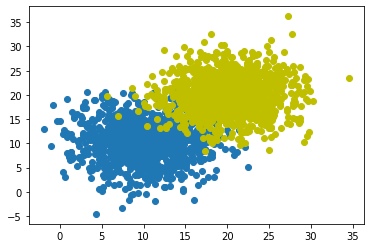

In [14]:
# On va suivre la même démarche mais en s'intéressant cette fois à la convergence du classifieur quand les données ne sont pas totalement linéairement séparables

rng = default_rng(190)

# On crée un jeu de données à partir de deux lois normales

dataset1 = rng.normal(10, 4, (1100, 2))
dataset2 = rng.normal(20, 4, (1100, 2))

dataset = np.concatenate((dataset1, dataset2), axis=0)
target = np.concatenate((np.zeros(1100), np.ones(1100)), axis=0)  # On crée le vecteur cible

# On affiche ce dataset

plt.scatter(dataset1.T[0], dataset1.T[1], color='tab:blue')
plt.scatter(dataset2.T[0], dataset2.T[1], color='y')
plt.show()

# On crée un dataset d'entraînement et un de test/validation

randomize =  np.arange(2200)# On crée d'abord un tableau d'entiers qu'on va mélanger, afin de mélanger notre dataset et de garder la correspondance entre les exemples et leur label dans le vecteur cible
rng.shuffle(randomize)

train_set = dataset[randomize[:2000]]
test_set = dataset[randomize[-2000:]]
train_target = target[randomize[:2000]]
test_target = target[randomize[-2000:]]


Affichage de l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement


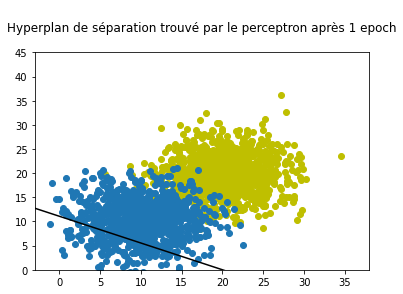

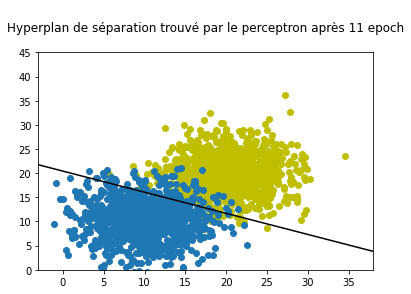

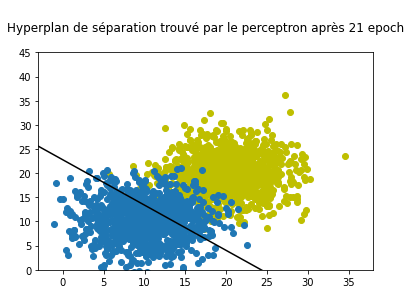

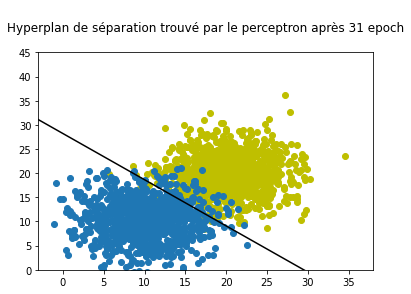

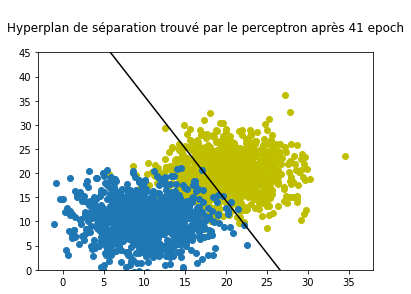

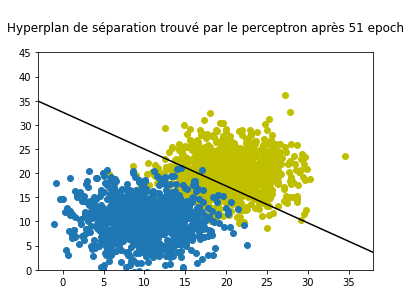

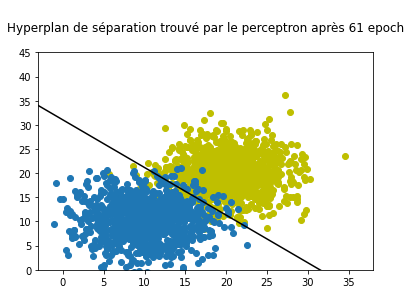

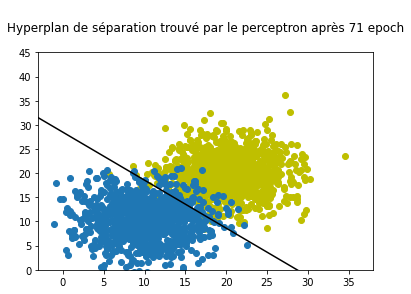

In [15]:
# On crée le perceptron

weights = rng.random(2)  # On initialise les poids du perceptron aléatoirement
bias = 1  # On fixe le biais arbitrairement à 1 
learning_rate = 0.5
activation_function = "heaviside"
gradient_descent_method = "SGD"  # On commence donc par une descente de gradient stochastique

perceptron = Classifier(weights, bias, learning_rate, activation_function, "SGD")  # On crée le perceptron, qui ici est un classifieur linéaire
errors = np.array([])  # Le tableau Numpy pour sotcker les erreurs

# On entraîne le perceptron

randomize = np.arange(2000)

Ntrain = 2000

epochs = 80

print("\nAffichage de l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement")

for j in range(epochs):
    for i in range(Ntrain):
        rng.shuffle(randomize)
        errors = np.append(errors, perceptron.training(train_set[randomize[i]], train_target[randomize[i]]))
    if not j % 10:  # On affiche l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement
        train_set_plot = train_set.T
        plt.scatter(train_set.T[0][train_target == True], train_set.T[1][train_target == True], color='y') 
        plt.scatter(train_set.T[0][train_target != True], train_set.T[1][train_target != True], color='tab:blue')
        plt.plot(np.linspace(-50, 50, 400), perceptron.hyperplan(np.linspace(-50, 50, 400)), color='k')
        plt.ylim(0, 45)
        plt.xlim(-3, 38)
        plt.title("\nHyperplan de séparation trouvé par le perceptron après {} epoch\n".format(j + 1))
        plt.show()

On observe que, sur les données d'entraînement, le perceptron se dirige relativement vite vers une zone de minima, mais l'hyperplan trouvé oscille de façon quand même considérable dans cette zone. Cela illustre encore les propos de Léon Bottou rappelés plus haut sur la descente assez rapide dans une zone de minima puis une convergence souvent plus lente ensuite avec des oscillations autour du minimum. Même quand l'hyperplan semble optimal ou presque, il va rebouger, c'est ce que l'on voit bien sur les graphes. 
Ces oscillations sont d'autant plus normales et même inévitable qu'ici, le problème n'est pas linéairement séparable. il existe une zone commune aux deux *clusters* de points où certains points d'un *cluster* sont plus proches de l'autre et inversement, et il est aisé de voir qu'on ne pourra pas les séparer distinctement à l'aide d'une droite. 

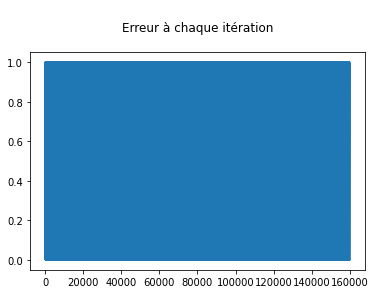

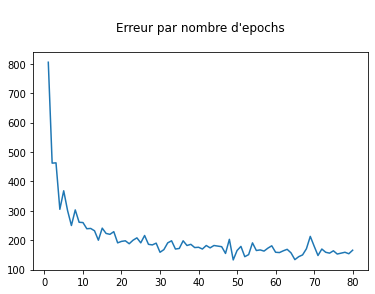

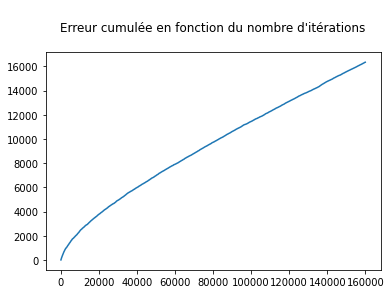

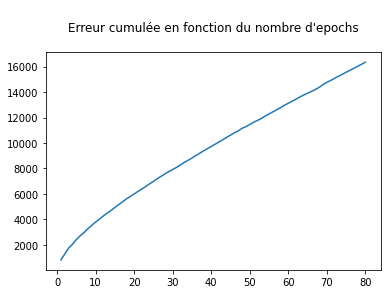


Pourcentage d'erreurs sur les 100 derniers exemples du train_set
 à la fin de l'entraînement : 5.0%



In [16]:
# On affiche les erreurs commises lors de l'entraînement

# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque itération\n")
plt.show()

# On affiche maintenant le nombre d'erreurs par epoch

errors_per_epoch = np.add.reduceat(errors, np.arange(0, epochs * Ntrain, Ntrain))

plt.plot(np.arange(1, epochs + 1), errors_per_epoch)
plt.title("\nErreur par nombre d'epochs\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'itérations

plt.plot(np.arange(1, epochs * Ntrain + 1), np.cumsum(errors))
plt.title("\nErreur cumulée en fonction du nombre d'itérations\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'epochs

plt.plot(np.arange(1, epochs + 1), np.cumsum(errors_per_epoch))
plt.title("\nErreur cumulée en fonction du nombre d'epochs\n")
plt.show()

# On affiche le pourcentage d'erreurs commises par le perceptron sur le train_set à la fin de son entraînement        

print("\nPourcentage d'erreurs sur les 100 derniers exemples du train_set\n à la fin de l'entraînement : {}%\n".format(np.sum(errors[-100:])))

In [17]:
# On regarde la précision sur le dataset de test/validation maintenant 

predictions = perceptron.feed_forward(test_set)
cost_function = perceptron.get_cost_function()
erreur = cost_function(test_target, predictions)
print("\nPourcentage d'erreur sur le dataset de validation : {}%\n".format(erreur * 100 / len(test_target)))


Pourcentage d'erreur sur le dataset de validation : 10.05%



On voit bien que l'erreur décroît très vite dès le début puis continue de décroître assez rapidement jusqu'à la 10-ième epoch, avant d'avoir une décroissance bien plus lente et de rester ensuite dans des oscillations permanentes.
On a ici fait 80 epochs de 1000 itérations chacune. Si l'on réduit ce nombre, on voit que l'erreur cumulée présente au début une légère bosse qui indique que l'erreur décroît rapidement. Puis la croissance linéaire observée ensuite est en accord qavec les oscillations observées et que le nombre d'erreurs stagne, ce qui est inévitable dans la mesure où le problème n'est pas linéairement séparable.

L'erreur sur le dataset d'entraînement est seulement de 5%, c'est plutôt bon. Mais on note ici une claire différence avec le dataset de validation où l'erreur est ici de 10.05 %, ce qui reste correcte mais est loin d'êter négligeable. Dans plusieurs applications, notamment en médecine, on peut penser qu'une précision inférieure à 98 voire 99% est très insuffisante. Quoiqu'il en soit on note l'importance de tester notre modèle sur un jeu de données qu'il n'a encore jamais vu pour avoir une idée de sa capacité de généralisation. 

## Avec un pas adaptatif


Affichage de l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement


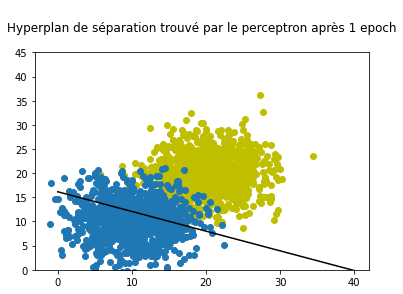

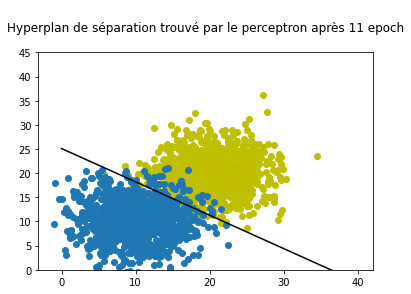

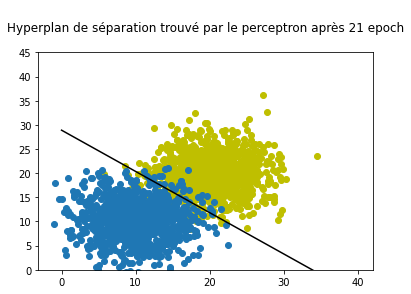

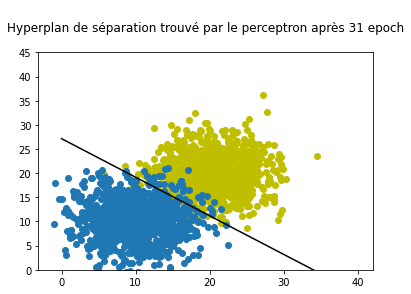

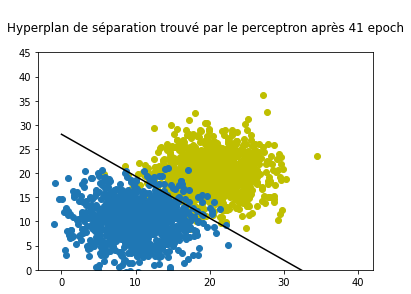

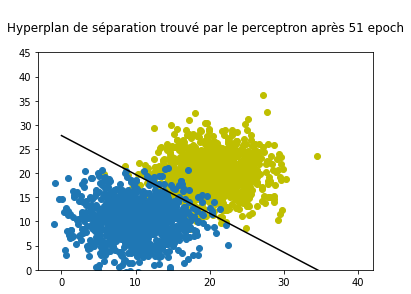

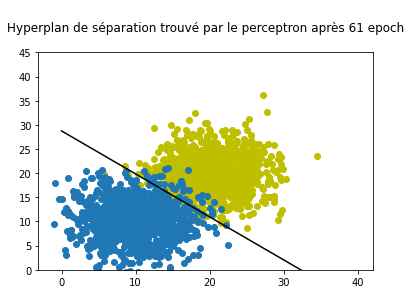

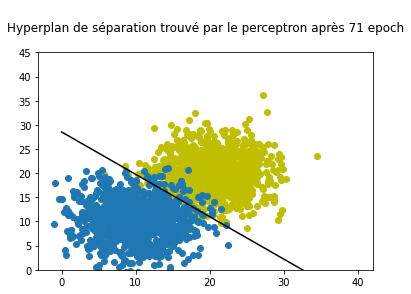


Pourcentage d'erreurs sur les 100 derniers exemples du train_set
 à la fin de l'entraînement : 2.0%



In [18]:
# on change la learning_rate

learning_rate = 1

perceptron = Classifier(weights, bias, learning_rate, activation_function, "SGD")  # On crée le perceptron, qui ici est un classifieur linéaire
errors = np.array([])  # Le tableau Numpy pour sotcker les erreurs

# On entraîne le perceptron

randomize = np.arange(2000)

Ntrain = 2000

epochs = 80

print("\nAffichage de l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement")

for j in range(epochs):
    for i in range(Ntrain):
        rng.shuffle(randomize)
        errors = np.append(errors, perceptron.training(train_set[randomize[i]], train_target[randomize[i]]))
        perceptron.update_learning_rate(update_function)  # On met à jour la learning rate
    if not j % 10:  # On affiche l'hyperplan à la première epoch et toutes les 10 epochs ensuite, sur les données d'entraînement
        train_set_plot = train_set.T
        plt.scatter(train_set.T[0][train_target == True], train_set.T[1][train_target == True], color='y') 
        plt.scatter(train_set.T[0][train_target != True], train_set.T[1][train_target != True], color='tab:blue')
        plt.plot(np.linspace(0, 40, 200), perceptron.hyperplan(np.linspace(0, 40, 200)), color='k')
        plt.ylim(0, 45)
        plt.title("\nHyperplan de séparation trouvé par le perceptron après {} epoch\n".format(j + 1))
        plt.show()

        
# On affiche le pourcentage d'erreurs commises par le perceptron sur le train_set à la fin de son entraînement        

print("\nPourcentage d'erreurs sur les 100 derniers exemples du train_set\n à la fin de l'entraînement : {}%\n".format(np.sum(errors[-100:])))

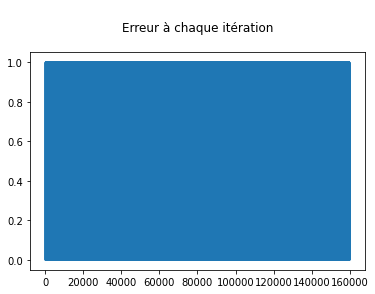

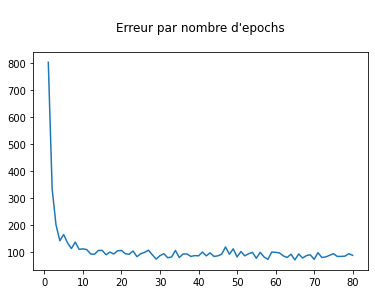

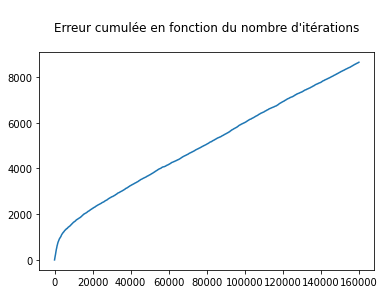

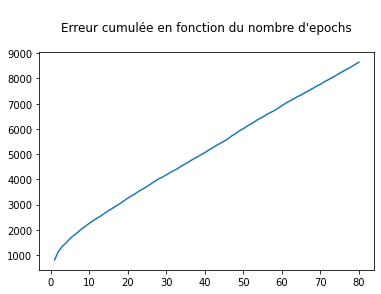

In [19]:
# On affiche les erreurs commises lors de l'entraînement

# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque itération\n")
plt.show()

# On affiche maintenant le nombre d'erreurs par epoch

errors_per_epoch = np.add.reduceat(errors, np.arange(0, epochs * Ntrain, Ntrain))

plt.plot(np.arange(1, epochs + 1), errors_per_epoch)
plt.title("\nErreur par nombre d'epochs\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'itérations

plt.plot(np.arange(1, epochs * Ntrain + 1), np.cumsum(errors))
plt.title("\nErreur cumulée en fonction du nombre d'itérations\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'epochs

plt.plot(np.arange(1, epochs + 1), np.cumsum(errors_per_epoch))
plt.title("\nErreur cumulée en fonction du nombre d'epochs\n")
plt.show()

In [20]:
# On regarde la précision sur le dataset de test/validation maintenant 

predictions = perceptron.feed_forward(test_set)
cost_function = perceptron.get_cost_function()
erreur = cost_function(test_target, predictions)
print("Pourcentage d'erreur sur le dataset de validation : {}%\n".format(erreur * 100 / len(test_target)))

Pourcentage d'erreur sur le dataset de validation : 4.15%



Encore une fois, on observe que la convergence est grandement facilitée avec un pas adaptatif. Non seulement l'erreur d'entraînement s'est réduite, mais surtout celle sur le dataset de validation a nettement diminué, ce qui est un très bon signe que le modèle arrive à généraliser. Surtout qu'ici il est impossible de n'avoir aucune erreur, donc on il est raisonnable de penser que le perceptron est ici dans un minimum global, ou du moins dans un minimum local très satisfaisant. 
Si on voit que le graphique des erreurs par nombre d'itérations et saturé car il est très fréquent de faire beaucoup d'erreurs sur autant d'itérations sur un problème non linéaire, on remarque en revanche que par epoch, l'erreur décroît bien plus vite que tout à l'heure puis oscille autour de 100.
Sur l'erreur cumulée en fonction du nombre d'itérations, la bosse qui ferait penser à l'amorce d'une croissance logarithmique indique encore que l'erreur a beaucoup diminué, plus rapidement qu'à pas constant donc, mais la croissance de cette erreur cumulée devient ensuite rapidement linéaire car on entame la phase des oscillations autour d'un minimum. 

# Descente de gradient par *batch*

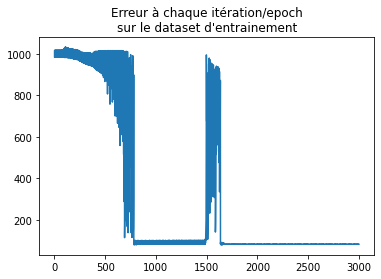


Pourcentage d'erreurs sur le train_set
 à la fin de l'entraînement : 4.1%



In [21]:
rng = default_rng(190)

learning_rate = 0.5
gradient_descent_method = "BGD"

epochs = 3000

perceptron2 = Classifier(weights, bias, learning_rate, activation_function, gradient_descent_method)  # On crée le perceptron, qui ici est un classifieur linéaire
errors = np.array([])  # Le tableau Numpy pour sotcker les erreurs

for j in range(epochs):
    errors = np.append(errors, perceptron2.training(train_set, train_target))

# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("Erreur à chaque itération/epoch\nsur le dataset d'entrainement")
plt.show()

# On affiche le pourcentage d'erreurs commises par le perceptron sur le train_set à la fin de son entraînement        

print("\nPourcentage d'erreurs sur le train_set\n à la fin de l'entraînement : {}%\n".format(errors[-1] * 100 / Ntrain))

In [22]:
# On regarde la précision sur le dataset de test/validation maintenant 

predictions = perceptron2.feed_forward(test_set)
cost_function = perceptron2.get_cost_function()
erreur = cost_function(test_target, predictions)
print("\nPourcentage d'erreur sur le dataset de validation : {}%\n".format(erreur * 100 / len(test_target)))


Pourcentage d'erreur sur le dataset de validation : 4.4%



À nombre d'exemples passés en revue égal, l'algorithme de descente de gradient par *batch* est vraiment beaucoup plus mauvais que celui stochastique, on ne peut pas dire qu'il a convergé vers un minimum. 

Il faut monter jusqu'à 3000 epochs, et donc 60000 exemples, pour que les résultats s'améliorent. L'algorithme stochastique, pour un même nombre d'exemples, fait là encore beaucoup mieux. Il est plus rapide, même si les deux algorithme atteignent à peu près le même niveau d'erreur de validation. 
On a testé avec 160 epochs, il y a en plus des moments où l'erreur peut grandement remonté, ce qui n'a pas l'air dêtre le cas avec l'algorithme stochastique, et notamment quand celui-ci est à pas adaptatif.

Le comportement du gradient par *batch* n'est pas celui attendu. Nous n'avons pas réussi à définir si c'était dû à une erreur dans le code ou pas. En regardant les ressources disponibles sur le net, il semble qu'il faille tout de même des hypothèses sur la régularité et/ou la convexité pour assurer la convergence vers un minimum. Peut-être que le fait que la fonction ne soit pas différentiable et que là on envoie des *batch* et pas exemple par exemple à l'algorithme empêche la convergence et empêche de se placer dans les conditions évoquées par Bottou où la non différentiabilité n'est pas un problème. 

# Regression 

On passe maintenant sur un problème de régression, certes très simple, mais qui permettra là encore de mettre en lumière le comportement de la descente de gradient stochastique et de comparer sa vitesse de convergence à celle de la descente de gradient par *batch*. Certaines différences apparaîtront plus nettement, étant donné que la fonction que l'on cherche à optimiser est convexe et suffisamment régulière. On retrouvera donc un comportement plus classique de la descente de gradient par batch, là où celle-ci pouvait surprendre sur les problèmes de classification examinés juste avant.

# Descente de gradient stochastique 

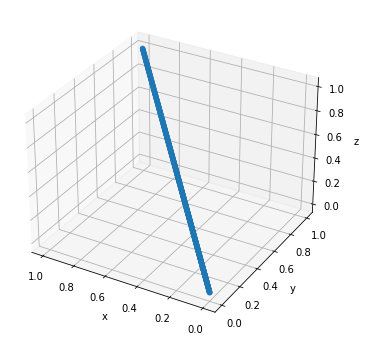

In [23]:
# On crée un dataset qui représente, dans R^3, la droite passant par l'origine et qui a pour vecteur directeur le vecteur (1, 1, 1) et t comme paramètre

line_point = np.zeros(3)  # Un point de la droite, ici elle passe donc par l'origine

direction_vector = np.ones(3)  # Le vecteur directeur
t = np.linspace(0, 1, 1100)  # Le paramètre t. On le choisit entre 0 et 1 car ça évite des soucis de renormalisation des données ou de choix d'un pas de départ très petit qui là aussi peut gêner 
# ce qu'on cherche à illustrer. Nous insistons toutefois sur l'importance, le cas échéant, de procéder à la normalisation des données, autrement la convergence peut s'en trouver grandement compromise. 
# Dans tous les cas, la normalisation améliore en générale la vitesse de convergence


u = np.array([1, 1, 1])  # un vecteur qui aidera à créer le dataset aux bonnes dimensions 
t_array = np.repeat(np.array([t]), 3, axis=0)


# Comme ça marche bien si je retranspose ensuite...

dataset = (line_point + (u * t_array.T)).T

# On affiche ce dataset

plt.rcParams['figure.figsize'] = (8, 6)
ax = plt.axes(projection='3d')

ax.invert_xaxis()

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

print()

ax.scatter3D(dataset[0], dataset[1], dataset[2])  # On affiche la droite qui est telle que x = y = z 
plt.show()

## Entraînement du perceptron

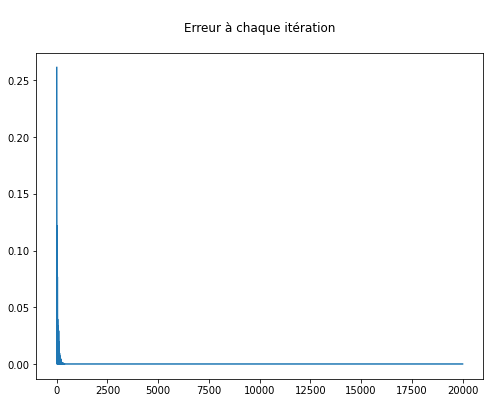

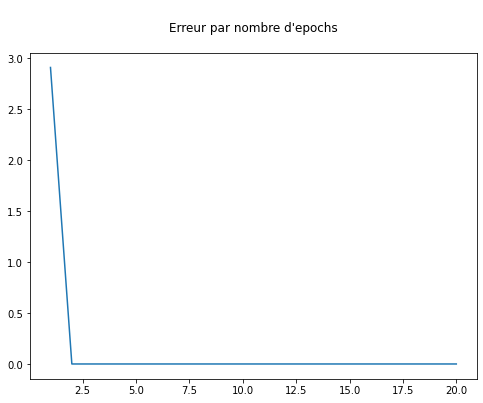

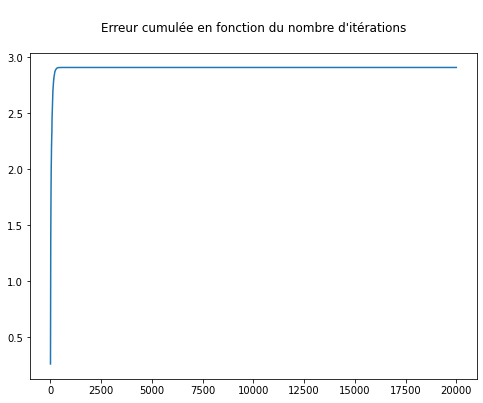

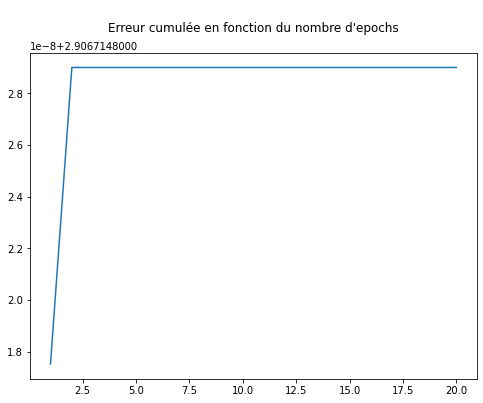


Valeur de l'erreur moyenne sur les 1000 derniers exemples du train_set
 à la fin de l'entraînement : 5.26521655165388e-33



In [24]:
# On met le dataset aux bonnes dimensions et on le divise entre une partie pour l'entraînement et une autre pour la validation, comme cela a été fait pour la classification

# Attention : on doit faire 200 epochs pour avoir une bonne idée de ce qui se passe, ce qui peut prendre un petit peu de temps. De plus, on utilisera ici directement tout le dataset. Du fait que ce que 
# l'on essaye d'apprendre via la régression linéaire est ici totalement linéaire puisqu'il s'agit d'une droite, découper le dataset en jeu d'entraînement et de test présente moins d'intérêt et 
# allongerait inutilement la longueur du code

dataset = (line_point + (u * t_array.T)).T  # On recrée le dataset ici pour éviter des erreurs si jamais il y a besoin de relancer la cellule 

rng = default_rng(190)  

dataset = dataset[:2,].T
target = dataset.T[-1]

train_set = dataset[:1000]
test_set = dataset[-100:]
train_target = target[:1000]
test_target = target[-100:]

Ntrain = 1000

# On initialise les hyperparamètres

weights = rng.random(2)  # On initialise les poids du perceptron aléatoirement
bias = 1  # On fixe le biais arbitrairement à 1 
learning_rate = 0.1
activation_function = "identity"  # On fait une régression ici, donc on utilise l'identité pour simplement récupérer la valeur du produit scalaire entre les poids et les features des données
gradient_descent_method = "SGD"  # On commence donc par une descente de gradient stochastique

# On crée le perceptron pour la régression

perceptron = Regressor(weights, bias, learning_rate, activation_function, gradient_descent_method)

errors = np.array([])
epochs = 20

randomize = np.arange(Ntrain)  # On crée le tableau d'entiers
rng.shuffle(randomize)  # On le mélange

for j in range(epochs): 
    for i in range(Ntrain):
        errors = np.append(errors, perceptron.training(train_set[randomize[i]], train_target[randomize[i]]))

# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque itération\n")
plt.show()

# On affiche maintenant le nombre d'erreurs par epoch

errors_per_epoch = np.add.reduceat(errors, np.arange(0, epochs * Ntrain, Ntrain))

plt.plot(np.arange(1, epochs + 1), errors_per_epoch)
plt.title("\nErreur par nombre d'epochs\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'itérations

plt.plot(np.arange(1, epochs * Ntrain + 1), np.cumsum(errors))
plt.title("\nErreur cumulée en fonction du nombre d'itérations\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'epochs

plt.plot(np.arange(1, epochs + 1), np.cumsum(errors_per_epoch))
plt.title("\nErreur cumulée en fonction du nombre d'epochs\n")
plt.show()

print("\nValeur de l'erreur moyenne sur les 1000 derniers exemples du train_set\n à la fin de l'entraînement : {}\n".format(np.mean(errors[-1000:])))

## Avec un pas adaptatif


Valeur du pas à la fin des epochs : 4.999975000124997e-06


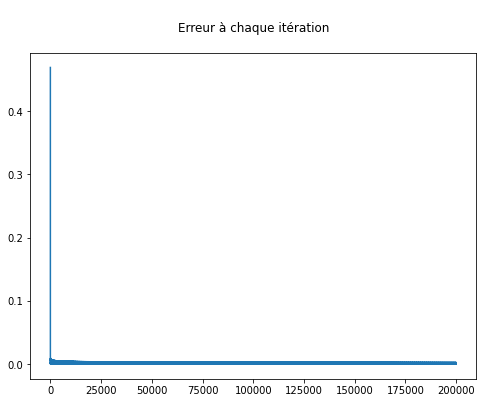

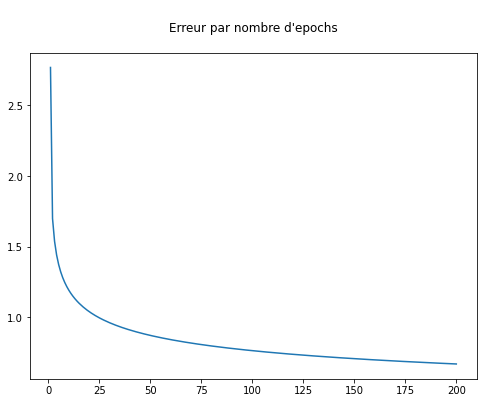

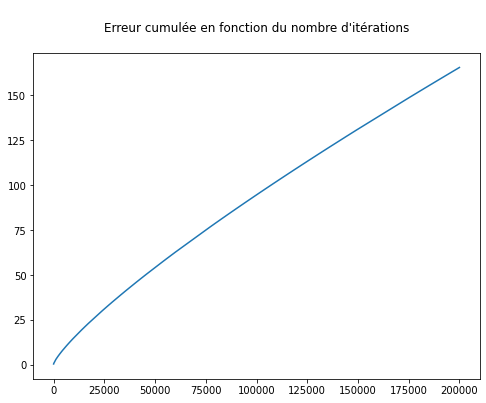

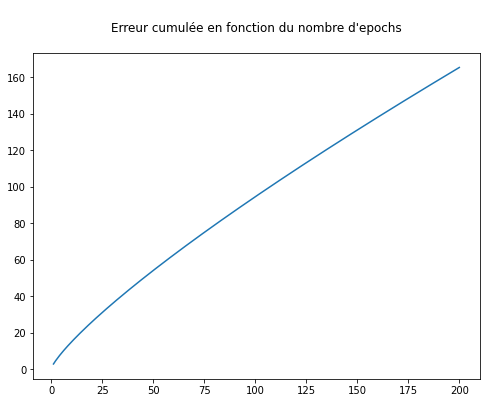


Valeur de l'erreur moyenne sur les 1000 derniers exemples du train_set
 à la fin de l'entraînement : 0.6686498436114798



In [25]:
# On va encore faire 200 epochs pour bien approcher la droite et également pour avoir une idée du comportement asymptotique 

rng = default_rng(190)

# On initialise les hyperparamètres

# On garde la même initialisation des poids et le même biais mais on change la learning rate
learning_rate = 1  # on met maintenant le pas d'apprentissage à 1 et il sera adaptatif, il décroît en 1/t.

perceptron = Regressor(weights, bias, learning_rate, activation_function, gradient_descent_method)

errors = np.array([])
epochs = 200

randomize = np.arange(Ntrain)  # On crée le tableau d'entiers
rng.shuffle(randomize)  # On le mélange

for j in range(epochs): ## OK j'ai un pb ici pour comparer mais faut que je revienne sur resultats avt
    for i in range(Ntrain):
        errors = np.append(errors, perceptron.training(train_set[randomize[i]], train_target[randomize[i]]))
        perceptron.update_learning_rate(update_function)

        
# On affiche la valeur du pas à la fin des itérations pour réaliser à quel point il a diminué

print("\nValeur du pas à la fin des epochs : {}".format(perceptron.get_learning_rate()))

# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque itération\n")
plt.show()

# On affiche maintenant le nombre d'erreurs par epoch

errors_per_epoch = np.add.reduceat(errors, np.arange(0, epochs * Ntrain, Ntrain))

plt.plot(np.arange(1, epochs + 1), errors_per_epoch)
plt.title("\nErreur par nombre d'epochs\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'itérations

plt.plot(np.arange(1, epochs * Ntrain + 1), np.cumsum(errors))
plt.title("\nErreur cumulée en fonction du nombre d'itérations\n")
plt.show()

# On affiche l'erreur cumulée selon le nombre d'epochs

plt.plot(np.arange(1, epochs + 1), np.cumsum(errors_per_epoch))
plt.title("\nErreur cumulée en fonction du nombre d'epochs\n")
plt.show()

print("\nValeur de l'erreur moyenne sur les 1000 derniers exemples du train_set\n à la fin de l'entraînement : {}\n".format(np.sum(errors[-1000:])))

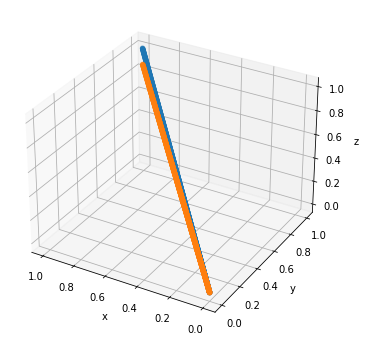

In [26]:
# On affiche l'hyperplan trouvé et la droite que l'on cherchait à approcher

dataset = (line_point + (u * t_array.T)).T

plt.rcParams['figure.figsize'] = (8, 6)
ax = plt.axes(projection='3d')

ax.invert_xaxis()

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

print()

ax.scatter3D(dataset[0], dataset[1], dataset[2])  # On affiche la droite qui est telle que x = y = z 
ax.scatter3D(dataset[0], dataset[1], np.dot(dataset[:2,].T, perceptron.get_weights()))  # On affiche l'hyperplan trouvé par le perceptron
plt.show()

On voit que la droite trouvée par le perceptron est relativement proche de celle que l'on désirait approcher, même quand on prend les poids de l'algorithme stochastic à pas adaptatif qui pourtant est moins performant ici que celui à pas constant. On avait testé avec 20 epochs, on a décidé ici de reproduire les résultats avec 200 epochs. On est certes un peu plus proche, mais c'est un bénéfice qui a demandé beaucoup de temps de calcul en plus. 

Remarquons également un fait intéressant. Ici l'algorithme à pas adaptatif est vraiment moins bien que celui à pas constant. Ce n'est pas contradictoire avec les résultats théoriques. En effet, un pas en 1/t garantit la convergence, mais en pratique il n'interdit pas qu'à pas constant on puisse converger, et surtout il n'empêche nullement que l'on ait une plus grande vitesse de convergence à pas constant. Ce qu'il se passe ici, c'est que la décroissance du pas fait qu'après plusieurs itérations, celui-ci devient si petit que, même si la convergence théorique reste garantie, quand on fait tourner concrètement l'algorithme en revanche on finit par ne presque plus rien changer, puisque le terme de mise à jour est multiplié avec le pas qui devient ridiculement petit. C'est donc quelque chose à garder en tête quand on doit implémenter les algorithmes. En plus, les choses ne sont pas trop compliquées dans le cas de cette régression linéaire simple. La fonction est convexe et a un unique minimum. Donc même si on reste avec un pas constant, quand on s'approche du minimum, le gradient diminue et donc si le pas n'est pas trop grand, on ajoutera quelque chose de suffisamment petit pour ne pas diverger. Mais dans le même temps, le pas constant permet de s'assurer que l'on ajoutera pas une quantité trop négligeable et que chaque itération pourra bien changer les poids, même légèrement, et améliorer la précision. Or, avec l'algotihme *online*, le pas atteint une valeur inférieur à 10^(-6), donc on finit par ne plus rien mettre à jour. On ne peut alors plus diminuer l'erreur, et même avant cela on ne la diminue pas autant qu'avec l'algorithme à pas constant. Donc si en théorie on converge, en pratique on se retrouve quasiment dans la même situation qu'avec une suite de pas dont la somme serait finie... et donc c'est presque comme si l'on se retrouvait dans la situation théorique où la convergence n'est pas garantie puisque la condition sur le pas n'est pas satisfaite. Encore une fois, elle est ici codée de sorte qu'on a du 1/t et donc le pas satisfait cette condition théorique, mais le déroulé concret de l'algorithme fait qu'on se retrouve quasiment dans la même situation que celle où l'on aurait choisit un pas qui ne satisfait pas la condition de convergence qui vient dêtre rappelée. 

Notons enfin qu'après quelques essais avec des poids différents (des initialisations des poids différentes plus exactement), on remarque une légère sensibilité à l'initialisation. Sur une initialisation différente, la droite trouvée était moins précise. Cela peut paraître étonnant dans le cas d'une régression linéaire, sur un problème à l'évidence linéaire, après autant d'itérations. Mais si le pas décroît assez vite, il n'est pas absurde de penser qu'il devient vite trop petit avant d'avoir pu apporter des changements suffisants. 

# Descente de gradient par *batch*

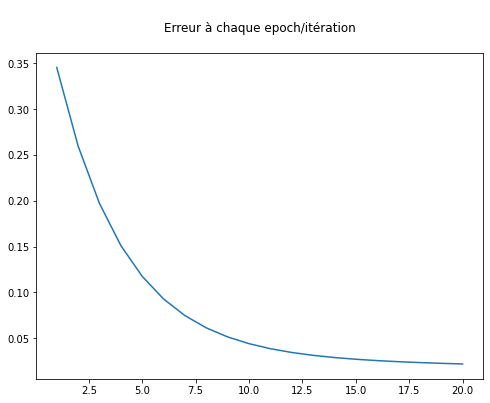


Valeur de l'erreur moyenne sur les 1000 derniers exemples du train_set
 à la fin de l'entraînement : 0.02196683941008935



In [27]:
# On recommence la même chose, cette fois-ci avec l'algorithme de descente de gradient par *batch*

# On garde les mêmes hyperparamètres à part évidemment celui donnant le type de descente, et la learning rate qui redevient constante

learning_rate = 0.1
gradient_descent_method = "BGD"  # On commence donc par une descente de gradient stochastique

perceptron = Regressor(weights, bias, learning_rate, activation_function, gradient_descent_method)

errors = np.array([])
epochs = 20

for j in range(epochs): ## OK j'ai un pb ici pour comparer mais faut que je revienne sur resultats avt
    errors = np.append(errors, perceptron.training(train_set, train_target))

# On affiche l'erreur faite à chaque itération

plt.plot(np.arange(1, len(errors) + 1), errors)
plt.title("\nErreur à chaque epoch/itération\n")
plt.show()

print("\nValeur de l'erreur moyenne sur les 1000 derniers exemples du train_set\n à la fin de l'entraînement : {}\n".format(errors[-1]))

Là encore, le comportement attendu des deux algorithmes et leurs différences sont bien observées. Notons que l'on retrouve le comportement typique de l'algorithme par *batch* dans le cadre d'une fonction de coût suffisamment régulière. Pour un pas suffisamment petit, il est garanti de converger vers un minimum local, dans le bassin (la région, le voisinnage des poids/paramètres si l'on préfère) à l'intérieur duquel les poids initiaux se trouvent. Et quand cette fonction est convexe, on sait alors que ce minimum est celui global. Ici il n'est pas dur de voir que le minimum global est zéro, c'est-à-dire que les poids trouvés par l'algorithme sont exactement ceux caractérisant la droite qu'on cherchait à approcher.
On voit d'ailleurs que la courbe des erreurs selon le nombre d'itération décroît justement à chaque itération, et a une pente assez typique pour ce genre de d'algorithme sur des problèmes de régression liénaire. Ce n'était pas le cas quand on a utilisé cette méthode de descente de gradient classique pour faire de la classification. 

En 20 epochs, i.e 20 000 exemples, l'algorithme stochastique à pas constant a déjà convergé vers le minimum. L'algorithme par *batch*, pour le même nombre d'exemples, fait beaucoup moins bien avec une erreur de l'ordre de 0.02. 

À nombre d'itérations égales, c'est à dire 20 000 epochs pour l'algorithme par *batch* (ce qui correspond à 20 epochs du stochastic étant donné le code qu'on a utilisé où une epoch pour le stochastique est composée d'un nombre Ntrain d'itérations), l'algorithme par *batch* a également convergé. Il lui a fallu toutefois regarder et donc sommer des gradients sur la base de beaucoup plus d'exemples, 20 000 000 ici, ce qui peut demander un temps de calcul considérable. 

Pour conclure cette partie, il nous semble très important de revenir sur la phrase précédente. Il y a en effet un aller-retour entre théorie et pratique, sûrement particulier aux mathématiques appliquées, qu'il est vital de bien saisir. 

Les résultats théoriques nous disent qu'en nombre d'itérations, l'algorithme de descente de gradient par *batch* converge plus rapidement. 
Néanmoins, il minimise le risque empirique, alors qu'en pratique, on se soucie du risque réel, autrement dit de la capacité à généraliser, qui est le critère d'un apprentissage réussie. 
Revenant à la théorie, il est possible de montrer que l'algorithme stochastique ne converge pas moins vite que celui par *batch* vers ce risque, ils y vont asymptotiquement à la même vitesse. On peut alors montrer que pour un même nombre d'exemples passés en revue par les deux algorithmes, celui stochastique sera asymptotiquement meilleur, raison pour laquelle d'ailleurs on l'utilise sur de grands jeux de données où la limite est moins le nombre d'exemples du dataset que le temps de calcul. 
Mais rappelons enfin que, comme le mentionne Léon Bottou dans son papier de 2003, en pratique cette complexité asymptotique nous intéresse moins que les constantes déterminant le temps de calcul des opérations que doit effectuer chaque algorithme. On en a ici une illustration parfaite. 
Regardant beaucoup plus d'exemples que dans le cas du gradient stochastique, on pourrait penser que l'algorithme par *batch* serait beaucoup plus lent à s'éxécuter. Or il n'en est rien. Après quelques recherches, il apparaît que les explications résident très probablement dans l'implémentation des algorithmes. Si on a utilisé python chacun d'eux, il est possible grâce à numpy de vectoriser les opérations de calculs de gradients, de somme et de mise à jour des poids. Or, cette vectorisation tire profit de l'architecture de l'ordinateur et accélère énormément les calculs. En outre, l'implémentation Numpy recourre à des langages beaucoup plus rapides, comme le C. 
Ainsi, si en théorie, comme il a besoin de plus d'exemples, l'algorithme par *batch* devrait s'éxécuter plus lentement, ces considérations pratiques font qu'il n'en est rien et que l'on semble même observer l'inverse. C'est d'ailleurs la raison pour laquelle on a parfois recourt à la méthode dite de *mini-batch*, qui constitue un mix des deux méthodes pour tirer profit des avantages de chacune d'elle. Ces aspects concrets sont à garder en tête quand on désire implémenter un algorithme dont on espère qu'il converge pour un certain temps de calcul donné et incite à toujours garder un peu de recul quand il s'agit de mettre en oeuvre les résultats théoriques.